# CORDEX-CORE urban vs rural vicinity analysis

...

## Load libraries

Here we load the required libraries to execute the notebook. Note that specific code from dedicated scripts (`utils.py`, `urban_areas.py`, ...) is also loaded here.

In [23]:
%load_ext autoreload
%autoreload 2
    
import cartopy.crs as ccrs
import cf_xarray as cfxr
import dask
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import sys
import xarray as xr

from icecream import ic
from itertools import product
from matplotlib.colors import LinearSegmentedColormap
from mpl_toolkits.axes_grid1 import make_axes_locatable
from shapely.geometry import Point
from skimage.morphology import dilation, square
from utils import RCM_DICT, MODEL_DICT, YAMLconfig

from urban_areas import (
    load_fix_variables,
    fix_sftuf,
    Urban_vicinity,
    load_variable,
    kelvin2degC,
    load_ucdb_city,
)
from GHCNd_stations import (
    load_ghcnd_stations,
    get_ghcnd_df,
    get_valid_timeseries,
    available_vars,
    get_season,
    inside_city
)
from plot_functions import (
    plot_climatology,
    plot_time_series
)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Input parameters

These parameters define the behaviour of the notebook, by selecting the `city`, `variable`, and some other items which are mostly self-explanatory. _(Explain here those with are not)_

This cell is tagged `parameters`, in order to be managed externally by the [`papermill` package](https://papermill.readthedocs.io/en/latest).

In [136]:
abbr_city = 'Athens'

variable = 'tasmin'
observations = True
domain = 'EUR-11'
model = 'RegCM' # REMO/RegCM
scenario = 'evaluation'
root_esgf = '/lustre/gmeteo/DATA/ESGF/REPLICA/DATA/cordex/output/'
root_nextcloud = '/lustre/gmeteo/WORK/DATA/CORDEX-FPS-URB-RCC/nextcloud/CORDEX-CORE-WG/'
base_output_dir = 'results'

lon_city = 23.72
lat_city =  37.98

urban_th = 0.1
urban_sur_th = 0.1
orog_diff = 100
sftlf_th = 70
scale = 2
min_city_size = 0 # remove small urban centers (numbero of cells)
lon_lim = 1
lat_lim = 1

Create a directory to save the results for this particular city and model

In [137]:
cities = YAMLconfig('selected_cities.yaml')
city = cities[abbr_city]['name']
model_str = RCM_DICT[domain][model]
output_dir = f"{base_output_dir}/{abbr_city}-{domain}_{model_str}"
os.makedirs(output_dir, exist_ok = True)

In [138]:
domain_resolution = int(domain.split('-')[1])
base_filename = f'{abbr_city}-{domain}_ECMWF-ERAINT_{scenario}_r1i1p1_{model_str}'

## Define urban areas and vicinity

### Load fix variables
Load fix (static) variables, such as urban fraction (sfturf), terrain elevation (orog) or land fraction (sftlf). The urban fraction needs some fixes to align the coordinates with the rest of the variables. These are applied in the `fix_sfturf` function.

In [139]:
ds_sftuf, ds_orog, ds_sftlf = load_fix_variables(domain, model, root_esgf, root_nextcloud)
ds_sftuf = fix_sftuf(domain, model, ds_sftuf, ds_orog, ds_sftlf)

Add parameters to the function

In [140]:
URBAN = Urban_vicinity(
    urban_th, 
    urban_sur_th, 
    orog_diff, 
    sftlf_th,
    scale,
    min_city_size,
    lon_city,
    lat_city,
    lon_lim,
    lat_lim,
    model_str,
    domain)

Crop area around de city

In [141]:
ds_sftuf = URBAN.crop_area_city(ds_sftuf, domain_resolution)
ds_orog = URBAN.crop_area_city(ds_orog, domain_resolution)
ds_sftlf = URBAN.crop_area_city(ds_sftlf, domain_resolution)

Define masks using the parameters above

In [142]:
sftuf_mask, sftuf_sur_mask, orog_mask, sftlf_mask = URBAN.define_masks(
    ds_sftuf, 
    ds_orog, 
    ds_sftlf
)

### Define rural vicinity areas

We use an iterative algorithm to select the urban vicinity excluding masked areas

In [143]:
urmask = URBAN.select_urban_vicinity(
    sftuf_mask, 
    orog_mask,
    sftlf_mask,
    sftuf_sur_mask
)

We can plot the masks and the urban vs vicinity areas. The latter are are passed via the `urban_areas` parameter. They are hidden if set to `None`.

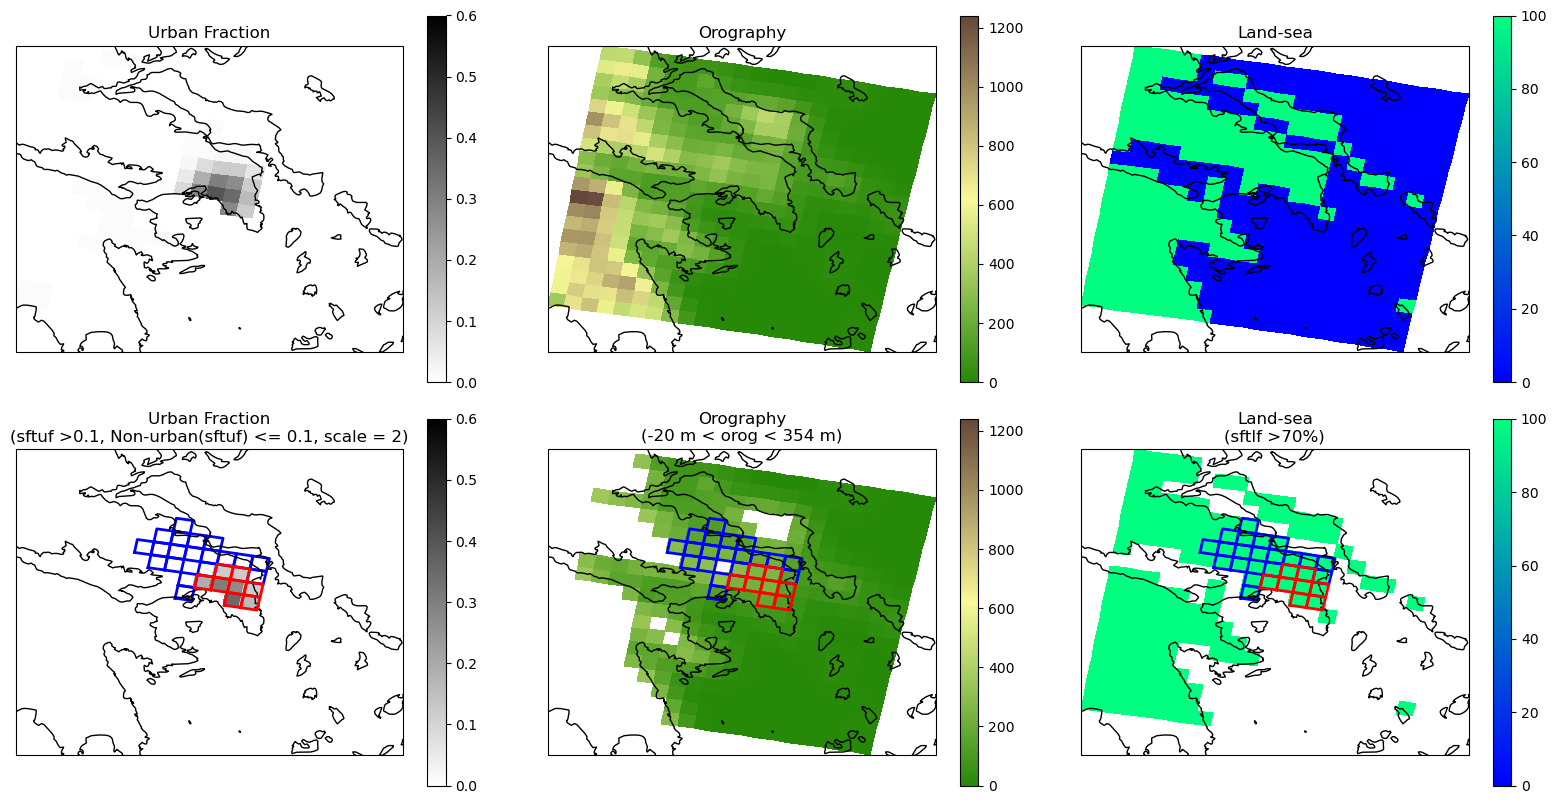

In [144]:
fig = URBAN.plot_fix_variables(ds_sftuf, ds_orog, ds_sftlf,
                                 sftuf_mask, orog_mask, sftlf_mask,
                                 urban_areas = urmask)
fig.savefig(f"{output_dir}/urmask_{base_filename}_fx.pdf", bbox_inches='tight')

Save these masks and urban fraction to NetCDF

In [145]:
urmask.to_netcdf(f"{output_dir}/urmask_{base_filename}_fx.nc")
ds_sftuf.rename_vars({'sftuf': 'sfturf'}).to_netcdf(f"{output_dir}/sfturf_{base_filename}_fx.nc")

## Calculate urban heat island effect

Remember that we selected above the following parameters:

In [146]:
ic(variable)
ic(city)
ic(observations);

ic| variable: 'tasmin'
ic| city: 'Athens'
ic| observations: True


### Load city shapefile

In [147]:
ucdb_city = load_ucdb_city(root_nextcloud, city)

### Load variable from ESGF DRS

In [ ]:
cachefile = f"{output_dir}/{variable}_{base_filename}_day.nc"
if os.path.exists(cachefile):
    print('Reading from cache file.')
    ds_RCM = xr.open_dataset(cachefile)
else:
    ds_RCM = load_variable(root_esgf, root_nextcloud, variable, domain, model, scenario)
    ds_RCM = kelvin2degC(ds_RCM, variable)
    ds_RCM = URBAN.crop_area_city(ds_RCM, domain_resolution)
    ds_RCM.to_netcdf(cachefile)

### Load observations

In [ ]:
radious = 0.5
GHCNd = load_ghcnd_stations(lon_city, lat_city, radious = 0.5)

### Select coincident period between Model and Observations

In [ ]:
valid_obs, time_series_obs, ds_RCM_period = get_valid_timeseries(
    city, GHCNd, ds_RCM, variable, idate='1979-01-01', fdate='2014-12-31')

In [ ]:
ds_RCM_period_season, time_series_obs_season = get_season(
    ds_RCM_period, time_series_obs, season = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12])

#### Calculate observations both inside and outside the city

In [ ]:
valid_obs = inside_city(valid_obs, ucdb_city)
if not isinstance(valid_obs, list):
    valid_obs.to_csv(f"{output_dir}/{variable}_{abbr_city}_{radious}_ghcnd_attributes.csv")
    time_series_obs_season.to_csv(f"{output_dir}/{variable}_{abbr_city}_{radious}_ghcnd_series_day.csv")

### Compute climatology of anomaly with respect to rural vicinity mean

In [ ]:
fig = plot_climatology(ds_RCM_period_season, ucdb_city, urmask, variable, 
                       URBAN, valid_obs, time_series_obs_season, city)
fig.savefig(f"{output_dir}/{variable}_{base_filename}_map-anom-wrt-rural.pdf", bbox_inches='tight')

In [ ]:
cachefile = f"{output_dir}/{variable}_{base_filename}_acycle-ur.nc"
fig = plot_time_series(ds_RCM, variable, urmask, 
    data_squares = True, city = city)
fig.savefig(cachefile.replace('.nc', '.pdf'), bbox_inches='tight')
plt.close()

In [ ]:
cachefile = f"{output_dir}/{variable}_{base_filename}_acycle-ur-obs.nc"
fig = plot_time_series(ds_RCM, variable, urmask,
    time_series = time_series_obs, valid_stations = valid_obs,
    data_squares = True, ucdb_city = ucdb_city, city = city)
fig.savefig(cachefile.replace('.nc', '.pdf'), bbox_inches='tight')